# Generaliza√ß√£o em Machine Learning

Neste notebook, vamos explorar um dos conceitos mais importantes em machine learning: **generaliza√ß√£o**. Veremos como os modelos se comportam quando expostos a dados que n√£o viram durante o treinamento e como evitar problemas como overfitting e underfitting.

## Objetivos de Aprendizagem

Ao final deste notebook, voc√™ ser√° capaz de:
- Compreender os conceitos de overfitting, underfitting e bias-variance tradeoff
- Implementar modelos polinomiais usando PyTorch para demonstrar estes conceitos
- Analisar curvas de treinamento para identificar problemas de generaliza√ß√£o
- Aplicar t√©cnicas de valida√ß√£o em datasets reais (Fashion-MNIST)

## Importa√ß√µes

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Configura√ß√£o para gr√°ficos
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Dispositivo utilizado: {device}')

Dispositivo utilizado: cpu


## 1. Conceitos Fundamentais de Generaliza√ß√£o

### 1.1 Defini√ß√µes

**Generaliza√ß√£o** √© a capacidade de um modelo de fazer predi√ß√µes precisas em dados que n√£o foram vistos durante o treinamento.

**Overfitting (Sobreajuste)**: O modelo aprende os dados de treinamento muito bem, incluindo ru√≠do e detalhes espec√≠ficos, mas falha em generalizar para novos dados.

**Underfitting (Subajuste)**: O modelo √© muito simples para capturar os padr√µes subjacentes nos dados, resultando em performance ruim tanto no treinamento quanto na valida√ß√£o.

### 1.2 Bias-Variance Tradeoff

O erro total de um modelo pode ser decomposto em tr√™s componentes:

$$\text{Erro Total} = \text{Bias}^2 + \text{Vari√¢ncia} + \text{Ru√≠do}$$

- **Bias**: Erro devido a suposi√ß√µes simplificadas no algoritmo de aprendizagem
- **Vari√¢ncia**: Erro devido √† sensibilidade a pequenas flutua√ß√µes no conjunto de treinamento
- **Ru√≠do**: Erro irredut√≠vel nos dados

![Bias-Variance Tradeoff](https://upload.wikimedia.org/wikipedia/commons/9/9f/Bias_and_variance_contributing_to_total_error.svg)

## 2. Demonstra√ß√£o com Regress√£o Polinomial

Vamos criar um exemplo pr√°tico usando regress√£o polinomial para demonstrar overfitting e underfitting.

### 2.1 Classe Polinomial Customizada

In [4]:
class PolynomialRegressor(nn.Module):
    """Modelo de regress√£o polinomial usando PyTorch.

    Implementa um polin√¥mio de grau n:
    y = a_0 + a_1*x + a_2*x^2 + ... + a_n*x^n
    """

    def __init__(self, degree):
        super(PolynomialRegressor, self).__init__()
        self.degree = degree
        # Coeficientes do polin√¥mio (par√¢metros aprend√≠veis)
        self.coefficients = nn.Parameter(torch.randn(degree + 1))

    def forward(self, x):
        """Forward pass: calcula o polin√¥mio para os valores de entrada."""
        # Criar matriz de pot√™ncias [1, x, x^2, x^3, ..., x^n]
        powers = torch.stack([x.squeeze()**i for i in range(self.degree + 1)], dim=1)
        # Calcular y = sum(a_i * x^i)
        return torch.sum(powers * self.coefficients, dim=1, keepdim=True)

    def get_coefficients(self):
        """Retorna os coeficientes aprendidos."""
        return self.coefficients.detach().numpy()

# Testar a classe
model = PolynomialRegressor(degree=2)
x_test = torch.linspace(-2, 2, 10).unsqueeze(1)
y_test = model(x_test)
print(f'Forma da entrada: {x_test.shape}')
print(f'Forma da sa√≠da: {y_test.shape}')
print(f'Coeficientes iniciais: {model.get_coefficients()}')

Forma da entrada: torch.Size([10, 1])
Forma da sa√≠da: torch.Size([10, 1])
Coeficientes iniciais: [-0.0381976   0.16836588  1.0674216 ]


### 2.2 Gera√ß√£o de Dados Sint√©ticos

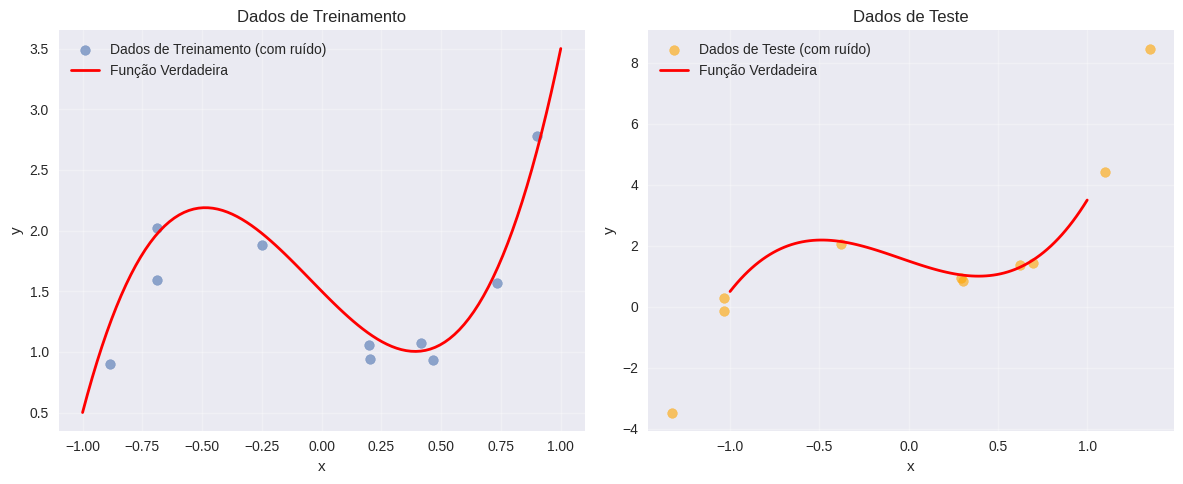

Tamanho do conjunto de treinamento: 10
Tamanho do conjunto de teste: 10


In [5]:
def generate_data(true_func, n_samples=100, noise_std=0.3, x_range=(-2, 2), seed=42, offset=0.0):
    """Gera dados com base em uma fun√ß√£o verdadeira e adiciona ru√≠do."""
    np.random.seed(seed)

    x = np.random.uniform(x_range[0]-offset, x_range[1]+offset, n_samples)
    y_true = true_func(x)
    noise = np.random.normal(0, noise_std, n_samples)
    y_noisy = y_true + noise

    return x, y_true, y_noisy

# Definir fun√ß√£o verdadeira (par√°bola)
def true_polynomial(x):
    return 1.5 - 2.0 * x + 0.5 * x**2 + 3.5 * x**3

x_range = (-1, 1)
noise_std = 0.2
test_offset = 0.5

# Gerar dados
x_train, y_train_true, y_train_noisy = generate_data(true_polynomial, n_samples=10, noise_std=noise_std, x_range=x_range)
x_test, y_test_true, y_test_noisy = generate_data(true_polynomial, n_samples=10, noise_std=noise_std, x_range=x_range, offset=test_offset)

# Converter para tensores
x_train_tensor = torch.FloatTensor(x_train).unsqueeze(1)
y_train_tensor = torch.FloatTensor(y_train_noisy).unsqueeze(1)
x_test_tensor = torch.FloatTensor(x_test).unsqueeze(1)
y_test_tensor = torch.FloatTensor(y_test_noisy).unsqueeze(1)

# Visualizar os dados
plt.figure(figsize=(12, 5))

x_smooth = np.linspace(x_range[0], x_range[1], 100)
y_smooth = true_polynomial(x_smooth)

plt.subplot(1, 2, 1)
plt.scatter(x_train, y_train_noisy, alpha=0.6, label='Dados de Treinamento (com ru√≠do)')
plt.plot(x_smooth, y_smooth, 'r-', label='Fun√ß√£o Verdadeira', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Dados de Treinamento')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(x_test, y_test_noisy, alpha=0.6, color='orange', label='Dados de Teste (com ru√≠do)')
plt.plot(x_smooth, y_smooth, 'r-', label='Fun√ß√£o Verdadeira', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Dados de Teste')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Tamanho do conjunto de treinamento: {len(x_train)}')
print(f'Tamanho do conjunto de teste: {len(x_test)}')

### 2.3 Fun√ß√£o de Treinamento

√âpoca 200/1000, Loss Treino: 0.0140, Loss Teste: 0.0924
√âpoca 400/1000, Loss Treino: 0.0140, Loss Teste: 0.1035
√âpoca 600/1000, Loss Treino: 0.0140, Loss Teste: 0.1035
√âpoca 800/1000, Loss Treino: 0.0140, Loss Teste: 0.1035
√âpoca 1000/1000, Loss Treino: 0.0140, Loss Teste: 0.1035

Coeficientes finais: [ 1.4131565  -2.0577047   0.44587064  3.85339   ]
Coeficientes verdadeiros: [1.5, -2.0, 0.5]


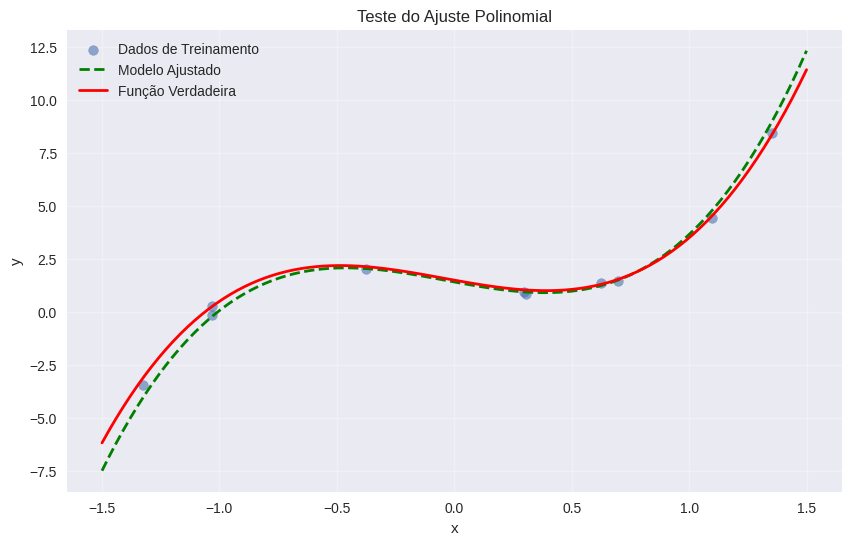

In [6]:
def train_polynomial_model(degree, epochs=1000, lr=0.01, verbose=False):
    """Treina um modelo polinomial e retorna hist√≥rico de losses."""
    model = PolynomialRegressor(degree)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Treinamento
        model.train()
        optimizer.zero_grad()
        train_pred = model(x_train_tensor)
        train_loss = criterion(train_pred, y_train_tensor)
        train_loss.backward()
        optimizer.step()

        # Avalia√ß√£o
        model.eval()
        with torch.no_grad():
            test_pred = model(x_test_tensor)
            test_loss = criterion(test_pred, y_test_tensor)

        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())

        if verbose and (epoch + 1) % 200 == 0:
            print(f'√âpoca {epoch+1}/{epochs}, '
                  f'Loss Treino: {train_loss:.4f}, '
                  f'Loss Teste: {test_loss:.4f}')

    return model, train_losses, test_losses

# Testar a fun√ß√£o de treinamento
model_test, train_losses_test, test_losses_test = train_polynomial_model(degree=3, epochs=1000, lr=0.1, verbose=True)
print(f'\nCoeficientes finais: {model_test.get_coefficients()}')
print(f'Coeficientes verdadeiros: [1.5, -2.0, 0.5]')

# Visualizar ajuste
plt.figure(figsize=(10, 6))
plt.scatter(x_test, y_test_noisy, alpha=0.6, label='Dados de Treinamento')
x_plot = torch.linspace(x_range[0]-test_offset, x_range[1]+test_offset, 100).unsqueeze(1)
with torch.no_grad():
    y_plot = model_test(x_plot)
plt.plot(x_plot.squeeze(), y_plot.squeeze(), 'g--', linewidth=2, label='Modelo Ajustado')
plt.plot(x_plot.squeeze(), true_polynomial(x_plot.squeeze()), 'r-', linewidth=2, label='Fun√ß√£o Verdadeira')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Teste do Ajuste Polinomial')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 2.4 Compara√ß√£o de Diferentes Graus de Complexidade

Agora vamos treinar modelos com diferentes graus polinomiais para demonstrar underfitting, bom ajuste e overfitting.

In [7]:
# Treinar modelos com diferentes graus
degrees = [1, 2, 3, 5, 8]
models = {}
histories = {}

print("Treinando modelos com diferentes graus...")
for degree in tqdm(degrees):
    model, train_losses, test_losses = train_polynomial_model(degree, epochs=5000, lr=0.01)
    models[degree] = model
    histories[degree] = {'train': train_losses, 'test': test_losses}

print("Treinamento conclu√≠do!")

Treinando modelos com diferentes graus...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5/5 [00:19<00:00,  3.99s/it]

Treinamento conclu√≠do!


In [8]:
import pandas as pd

results = []
for degree in degrees:
    train_mse = histories[degree]['train'][-1]
    test_mse = histories[degree]['test'][-1]
    gap = test_mse - train_mse

    results.append({
        'Grau': degree,
        'MSE Treino': f'{train_mse:.4f}',
        'MSE Teste': f'{test_mse:.4f}',
        'Gap': f'{gap:.4f}'
    })

df_results = pd.DataFrame(results)
print("=== AN√ÅLISE COMPARATIVA DOS MODELOS ===")
print(df_results.to_string(index=False))

# Visualizar coeficientes aprendidos
print("\n=== COEFICIENTES APRENDIDOS ===")
for degree in degrees:
    coeffs = models[degree].get_coefficients()
    print(f"Grau {degree}: {coeffs[:min(len(coeffs), 6)]}")

=== AN√ÅLISE COMPARATIVA DOS MODELOS ===
 Grau MSE Treino MSE Teste     Gap
    1     0.3330    8.0395  7.7065
    2     0.2501    7.5958  7.3457
    3     0.0140    0.1035  0.0895
    5     0.0132    1.3052  1.2919
    8     0.0133   18.6785 18.6651

=== COEFICIENTES APRENDIDOS ===
Grau 1: [1.467527   0.16260216]
Grau 2: [1.0930387  0.21707943 1.0318661 ]
Grau 3: [ 1.4131545  -2.0577023   0.44587454  3.8533862 ]
Grau 5: [ 1.3850608  -1.8643543   0.58041245  2.9321253  -0.1511887   0.8914164 ]
Grau 8: [ 1.4120996 -1.8983029  0.1328649  3.8155296  0.7973808 -1.8662627]


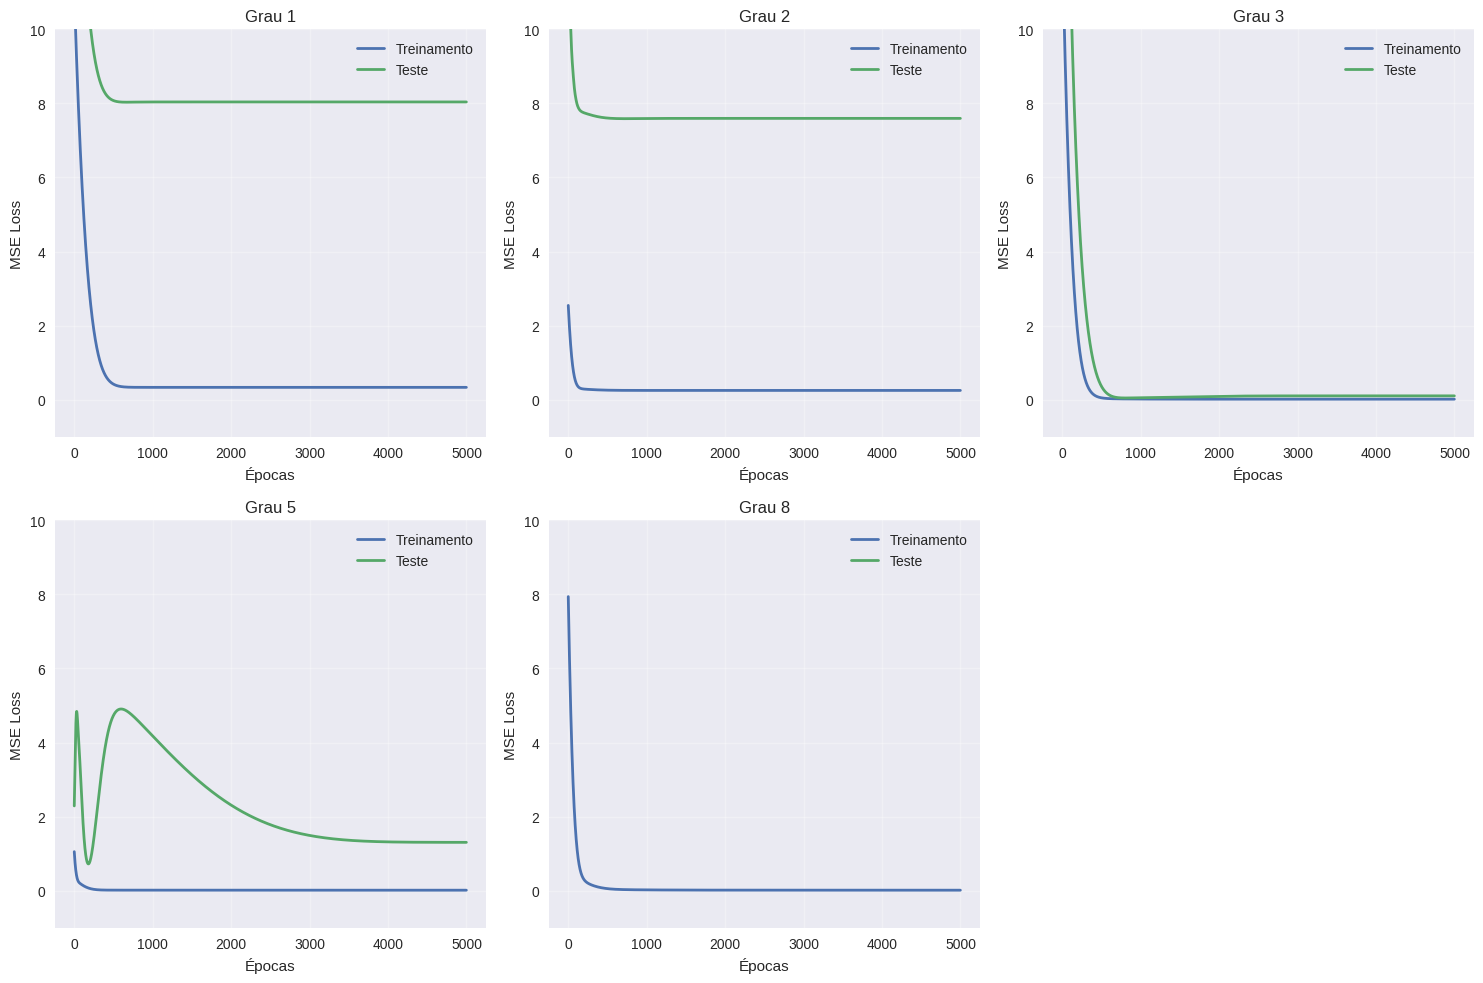

In [9]:
# Visualizar curvas de loss
plt.figure(figsize=(15, 10))

for i, degree in enumerate(degrees):
    plt.subplot(2, 3, i + 1)

    train_losses = histories[degree]['train']
    test_losses = histories[degree]['test']

    plt.plot(train_losses, label='Treinamento', linewidth=2)
    plt.plot(test_losses, label='Teste', linewidth=2)
    plt.xlabel('√âpocas')
    plt.ylabel('MSE Loss')
    plt.title(f'Grau {degree}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(-1, 10)

plt.tight_layout()
plt.show()

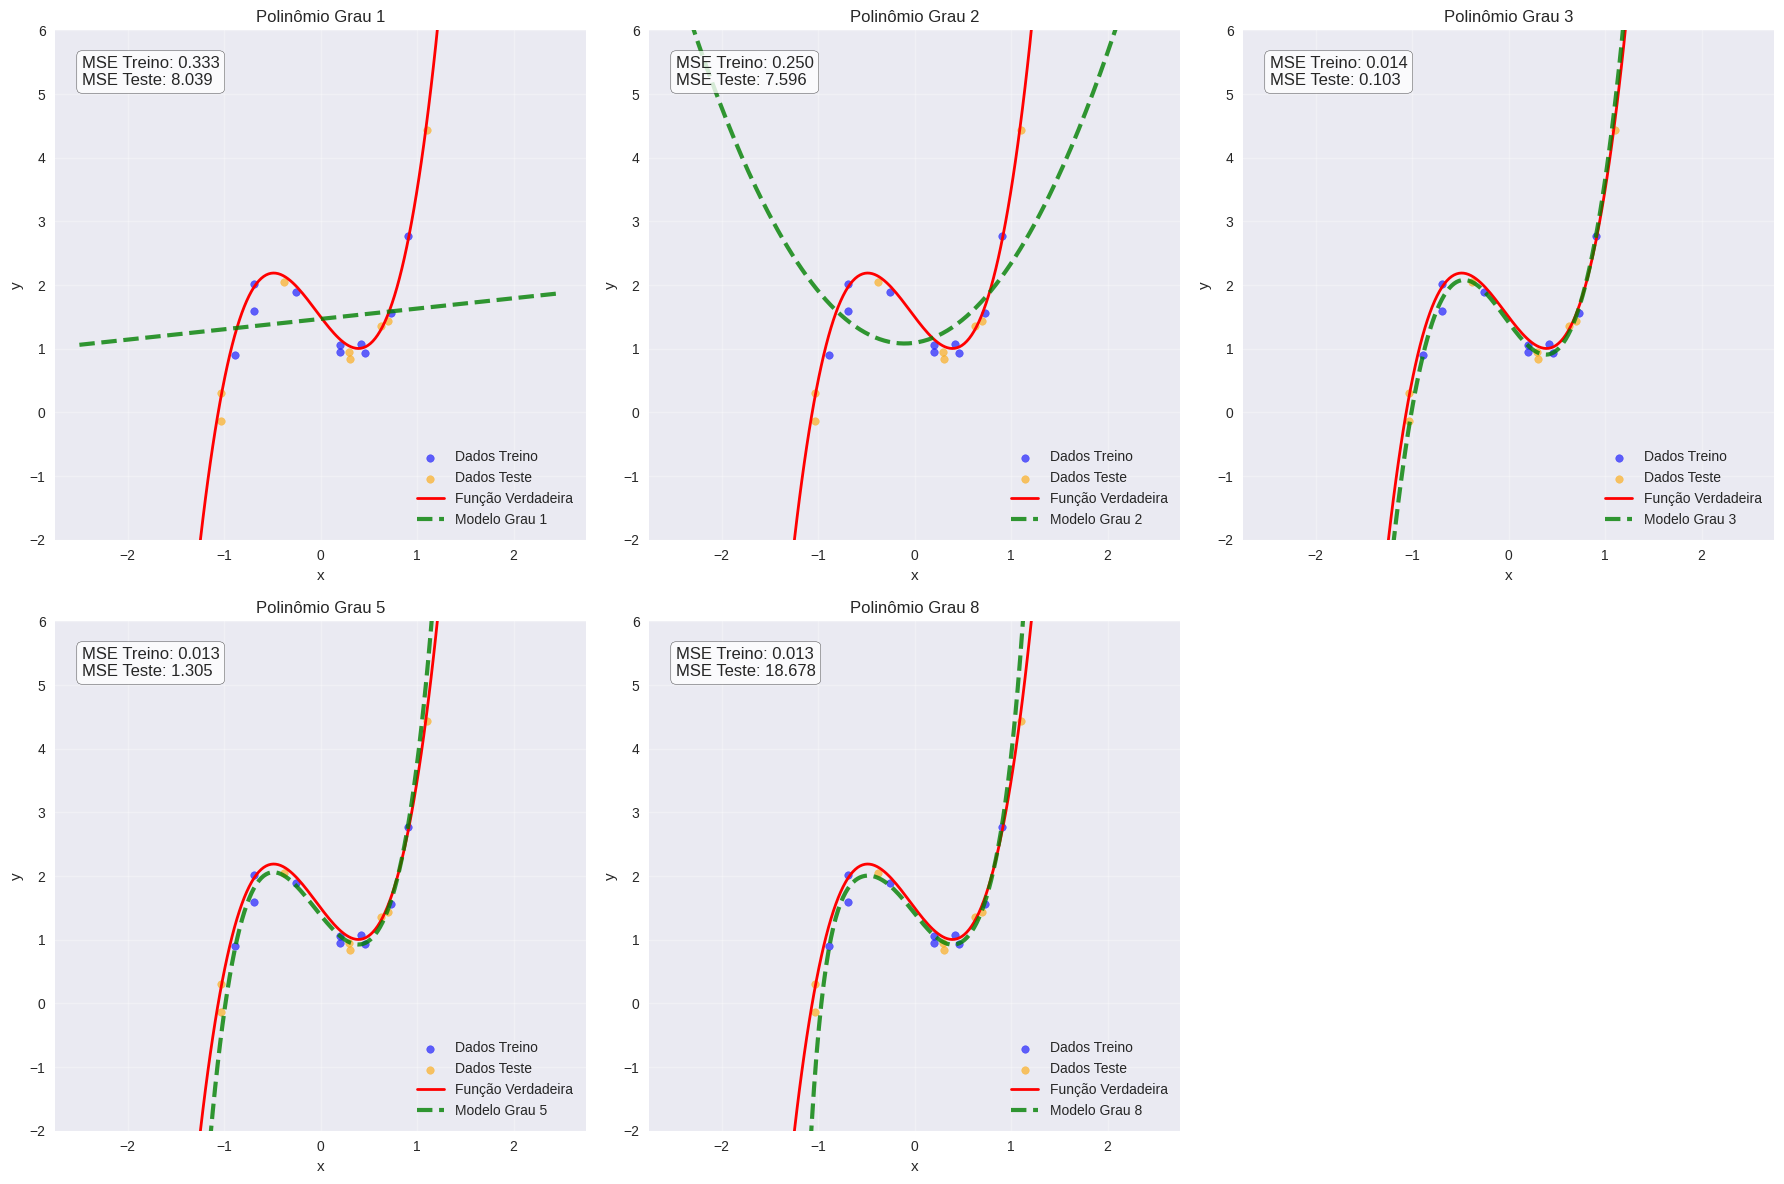

In [10]:
# Visualizar as predi√ß√µes dos modelos
x_plot = torch.linspace(-2.5, 2.5, 200).unsqueeze(1)
y_true_plot = true_polynomial(x_plot)

plt.figure(figsize=(18, 12))

for i, degree in enumerate(degrees):
    plt.subplot(2, 3, i + 1)

    # Dados de treinamento
    plt.scatter(x_train, y_train_noisy, alpha=0.6, color='blue', s=30, label='Dados Treino')
    plt.scatter(x_test, y_test_noisy, alpha=0.6, color='orange', s=30, label='Dados Teste')

    # Fun√ß√£o verdadeira
    plt.plot(x_plot.squeeze(), y_true_plot, 'r-', linewidth=2, label='Fun√ß√£o Verdadeira')

    # Predi√ß√£o do modelo
    model = models[degree]
    model.eval()
    with torch.no_grad():
        y_pred_plot = model(x_plot)

    plt.plot(x_plot.squeeze(), y_pred_plot.squeeze(), 'g--', linewidth=3,
             label=f'Modelo Grau {degree}', alpha=0.8)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Polin√¥mio Grau {degree}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(-2, 6)

    # Calcular erros finais
    train_mse = histories[degree]['train'][-1]
    test_mse = histories[degree]['test'][-1]

    plt.text(0.05, 0.95, f'MSE Treino: {train_mse:.3f}\nMSE Teste: {test_mse:.3f}',
             transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             verticalalignment='top')

plt.tight_layout()
plt.show()

## 3. Bias-Variance Tradeoff

### 3.1 Fundamentos Matem√°ticos

O **Bias-Variance Tradeoff** √© um conceito fundamental para entender por que modelos generalizam bem ou mal. Matematicamente, podemos decompor o erro esperado de um modelo:

$$E[(y - \hat{f}(x))^2] = \text{Bias}^2[\hat{f}(x)] + \text{Var}[\hat{f}(x)] + \sigma^2$$

Onde:
- **$y$**: valor verdadeiro
- **$\hat{f}(x)$**: predi√ß√£o do modelo
- **$\sigma^2$**: ru√≠do irredut√≠vel nos dados

#### Defini√ß√µes Matem√°ticas:

1. **Bias (Vi√©s)**: Mede o quanto a predi√ß√£o m√©dia do modelo se afasta do valor verdadeiro
   $$\text{Bias}[\hat{f}(x)] = E[\hat{f}(x)] - f(x)$$

2. **Vari√¢ncia**: Mede o quanto as predi√ß√µes variam entre diferentes conjuntos de treinamento
   $$\text{Var}[\hat{f}(x)] = E[(\hat{f}(x) - E[\hat{f}(x)])^2]$$

#### Interpreta√ß√£o Pr√°tica:

- **Alto Bias, Baixa Vari√¢ncia**: Modelo consistente, mas sistematicamente errado (underfitting)
- **Baixo Bias, Alta Vari√¢ncia**: Modelo correto em m√©dia, mas muito sens√≠vel aos dados (overfitting)
- **Objetivo**: Encontrar o equil√≠brio que minimiza o erro total

## 4. An√°lise de Overfitting com MNIST

### 4.1 Efeito do Tamanho do Dataset de Treinamento

Vamos investigar como o tamanho do conjunto de treinamento afeta o overfitting usando o dataset MNIST. Iremos treinar redes neurais com diferentes quantidades de dados de treinamento e observar como isso impacta a generaliza√ß√£o.

#### Hip√≥teses:
- **Poucos dados**: Alto overfitting (grande gap entre treino e valida√ß√£o)
- **Mais dados**: Menor overfitting e melhor generaliza√ß√£o
- **Muitos dados**: Converg√™ncia para o limite te√≥rico de performance

In [11]:
# Carregar o dataset MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normaliza√ß√£o espec√≠fica do MNIST
])

# Carregar datasets completos
train_dataset_full = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

# Criar dataloader para teste (fixo para todas as experi√™ncias)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print(f'Dataset MNIST carregado!')
print(f'Tamanho do conjunto de treinamento completo: {len(train_dataset_full)}')
print(f'Tamanho do conjunto de teste: {len(test_dataset)}')

Dataset MNIST carregado!
Tamanho do conjunto de treinamento completo: 60000
Tamanho do conjunto de teste: 10000


### 4.2 Arquitetura da Rede Neural

In [12]:
class MNISTClassifier(nn.Module):
    """Rede neural simples para classifica√ß√£o MNIST."""

    def __init__(self, hidden_size=128):
        super(MNISTClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Testar a arquitetura
model_test = MNISTClassifier(hidden_size=128)
print(f'Arquitetura do modelo:')
print(model_test)

# Contar par√¢metros
total_params = sum(p.numel() for p in model_test.parameters())
trainable_params = sum(p.numel() for p in model_test.parameters() if p.requires_grad)
print(f'\nTotal de par√¢metros: {total_params:,}')
print(f'Par√¢metros trein√°veis: {trainable_params:,}')

Arquitetura do modelo:
MNISTClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

Total de par√¢metros: 118,282
Par√¢metros trein√°veis: 118,282


### 4.3 Fun√ß√£o de Treinamento e Avalia√ß√£o

In [13]:
def train_mnist_model(train_loader, val_loader, epochs=20, lr=0.001, hidden_size=128):
    """Treina modelo MNIST e retorna hist√≥rico de m√©tricas."""

    model = MNISTClassifier(hidden_size=hidden_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Treinamento
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Avalia√ß√£o no conjunto de valida√ß√£o
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        # Calcular m√©tricas da √©poca
        train_loss_avg = train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total
        val_loss_avg = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total

        train_losses.append(train_loss_avg)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss_avg)
        val_accuracies.append(val_acc)

        if (epoch + 1) % 5 == 0:
            print(f'√âpoca {epoch+1}/{epochs}: '
                  f'Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.2f}% | '
                  f'Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.2f}%')

    return model, {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }

### 4.4 Experimento: Variando o Tamanho do Dataset de Treinamento

In [14]:
# Definir diferentes tamanhos de dataset para o experimento
dataset_sizes = [100, 500, 10000]  # Poucos, m√©dio e muitos dados
batch_size = 64
val_size = 1000  # Conjunto de valida√ß√£o fixo para compara√ß√£o justa

# Separar dados de valida√ß√£o (primeiros 5000 exemplos do conjunto de teste)
val_indices = list(range(val_size))
val_dataset = torch.utils.data.Subset(train_dataset_full, val_indices)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
epochs = 20

# Inicializar dicion√°rios para armazenar resultados
results_by_size = {}
models_by_size = {}

print("=== EXPERIMENTO: EFEITO DO TAMANHO DO DATASET ===")
print(f"Conjunto de valida√ß√£o fixo: {val_size} exemplos")
print(f"Tamanhos de treinamento a testar: {dataset_sizes}")
print(f"√âpocas por experimento: {epochs}")

=== EXPERIMENTO: EFEITO DO TAMANHO DO DATASET ===
Conjunto de valida√ß√£o fixo: 1000 exemplos
Tamanhos de treinamento a testar: [100, 500, 10000]
√âpocas por experimento: 20


In [15]:
# Executar experimentos para cada tamanho de dataset
for size in dataset_sizes:
    print(f"Treinando com {size} exemplos...")

    # Criar subset do dataset de treinamento
    # Usar √≠ndices ap√≥s os de valida√ß√£o para evitar overlap
    train_indices = list(range(val_size, val_size + size))
    train_subset = torch.utils.data.Subset(train_dataset_full, train_indices)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

    # Treinar modelo
    model, history = train_mnist_model(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=epochs,
        lr=0.001,
        hidden_size=128
    )

    # Armazenar resultados
    results_by_size[size] = history
    models_by_size[size] = model

    print(f"Conclu√≠do para {size} exemplos")

print("Todos os experimentos conclu√≠dos!")

Treinando com 100 exemplos...
√âpoca 5/20: Train Loss: 1.4981, Train Acc: 72.00% | Val Loss: 1.6319, Val Acc: 51.70%
√âpoca 10/20: Train Loss: 0.5100, Train Acc: 96.00% | Val Loss: 0.9993, Val Acc: 72.70%
√âpoca 15/20: Train Loss: 0.1279, Train Acc: 99.00% | Val Loss: 0.9089, Val Acc: 71.00%
√âpoca 20/20: Train Loss: 0.0312, Train Acc: 100.00% | Val Loss: 0.9228, Val Acc: 73.10%
Conclu√≠do para 100 exemplos
Treinando com 500 exemplos...
√âpoca 5/20: Train Loss: 0.4529, Train Acc: 87.60% | Val Loss: 0.5502, Val Acc: 84.00%
√âpoca 10/20: Train Loss: 0.1281, Train Acc: 98.80% | Val Loss: 0.4518, Val Acc: 85.60%
√âpoca 15/20: Train Loss: 0.0452, Train Acc: 99.80% | Val Loss: 0.4819, Val Acc: 85.60%
√âpoca 20/20: Train Loss: 0.0149, Train Acc: 100.00% | Val Loss: 0.5098, Val Acc: 86.20%
Conclu√≠do para 500 exemplos
Treinando com 10000 exemplos...
√âpoca 5/20: Train Loss: 0.0956, Train Acc: 97.26% | Val Loss: 0.2167, Val Acc: 94.00%
√âpoca 10/20: Train Loss: 0.0236, Train Acc: 99.33% | Val L

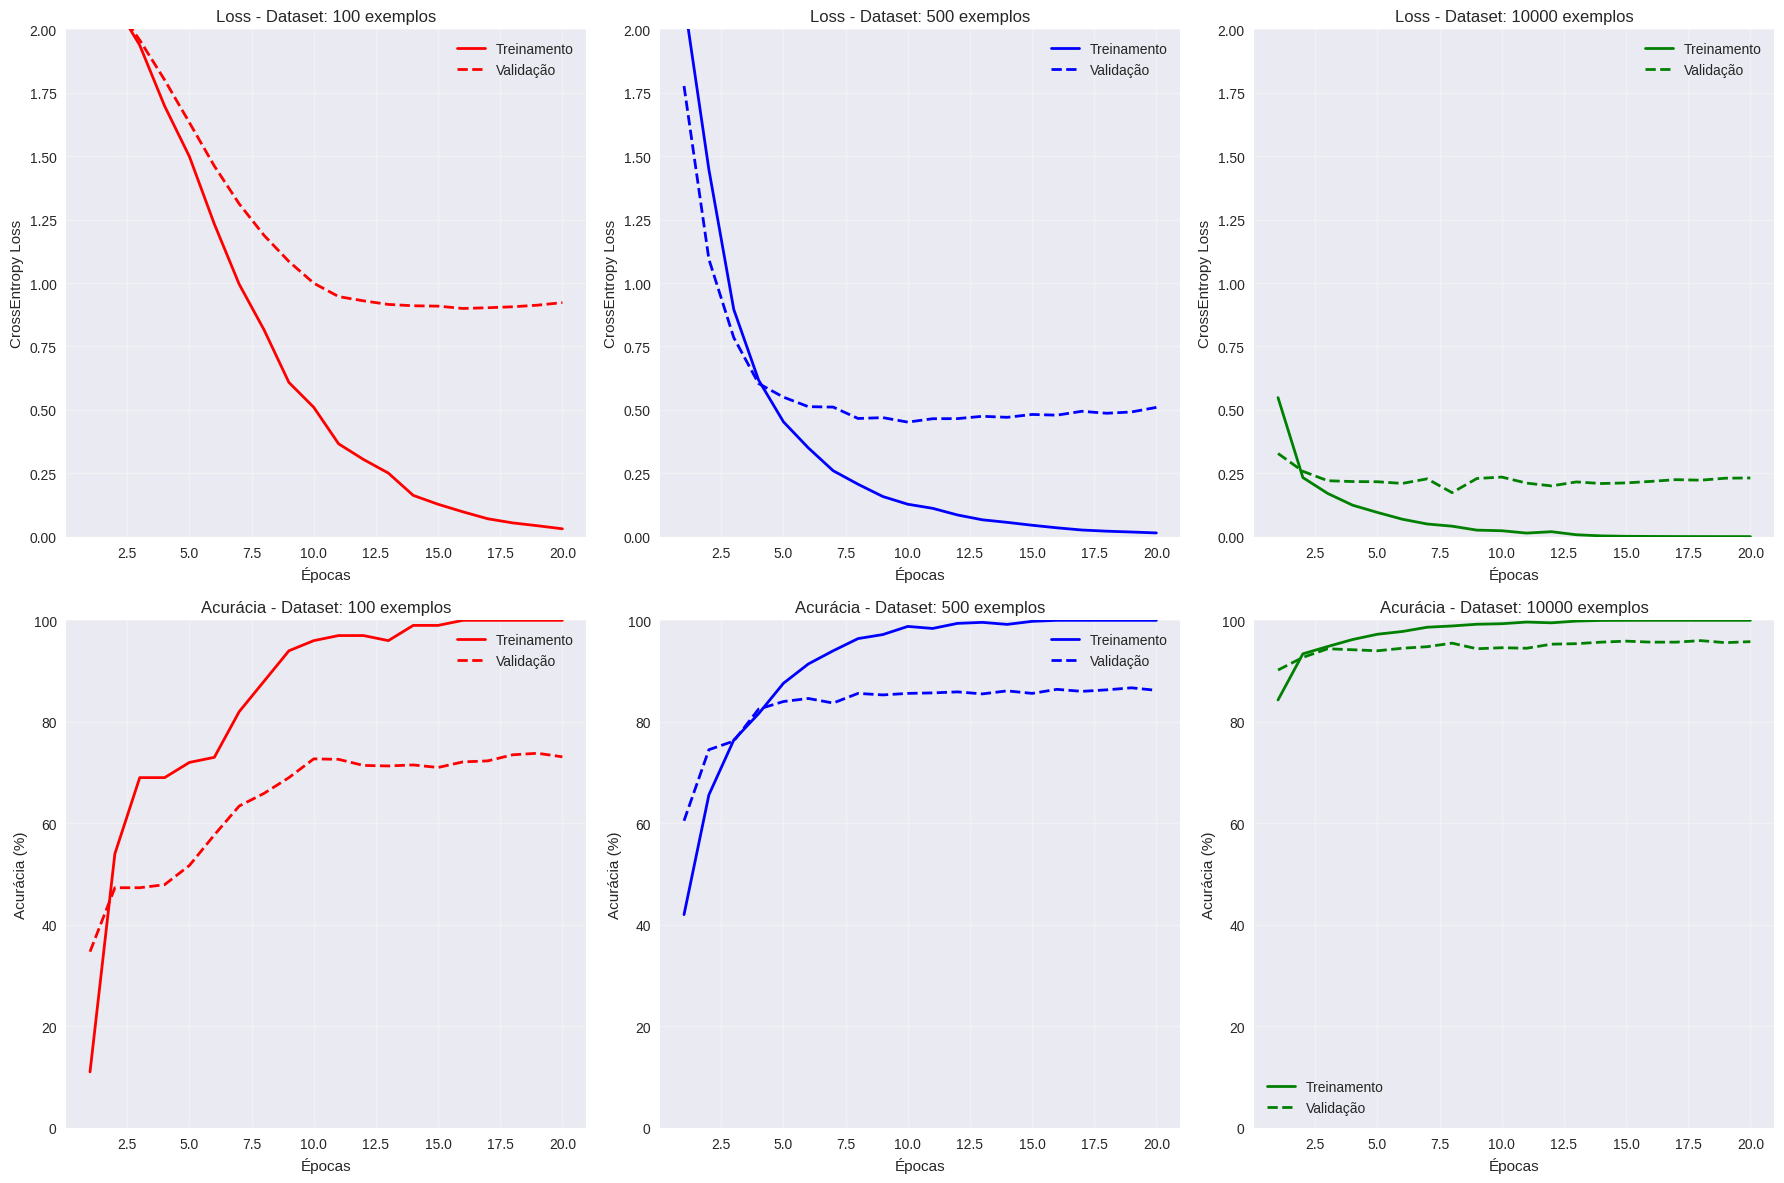

In [16]:
# Visualizar curvas de treinamento
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
colors = ['r', 'b', 'g']

for i, size in enumerate(dataset_sizes):
    history = results_by_size[size]
    color = colors[i]

    # Curvas de loss
    ax_loss = axes[0, i]
    epochs_range = range(1, len(history['train_losses']) + 1)
    ax_loss.plot(epochs_range, history['train_losses'], f'{color}-', linewidth=2, label='Treinamento')
    ax_loss.plot(epochs_range, history['val_losses'], f'{color}--', linewidth=2, label='Valida√ß√£o')
    ax_loss.set_title(f'Loss - Dataset: {size} exemplos')
    ax_loss.set_xlabel('√âpocas')
    ax_loss.set_ylabel('CrossEntropy Loss')
    ax_loss.legend()
    ax_loss.grid(True, alpha=0.3)
    ax_loss.set_ylim([0, 2])

    # Curvas de acur√°cia
    ax_acc = axes[1, i]
    ax_acc.plot(epochs_range, history['train_accuracies'], f'{color}-', linewidth=2, label='Treinamento')
    ax_acc.plot(epochs_range, history['val_accuracies'], f'{color}--', linewidth=2, label='Valida√ß√£o')
    ax_acc.set_title(f'Acur√°cia - Dataset: {size} exemplos')
    ax_acc.set_xlabel('√âpocas')
    ax_acc.set_ylabel('Acur√°cia (%)')
    ax_acc.legend()
    ax_acc.grid(True, alpha=0.3)
    ax_acc.set_ylim([0, 100])

plt.tight_layout()
plt.show()

### 4.5 An√°lise dos Resultados

In [17]:
# Analisar resultados finais
print("=== AN√ÅLISE DE OVERFITTING POR TAMANHO DO DATASET ===\\n")

analysis_results = []
for size in dataset_sizes:
    history = results_by_size[size]

    # M√©tricas finais (√∫ltima √©poca)
    final_train_loss = history['train_losses'][-1]
    final_val_loss = history['val_losses'][-1]
    final_train_acc = history['train_accuracies'][-1]
    final_val_acc = history['val_accuracies'][-1]

    # Gap entre treino e valida√ß√£o (indicador de overfitting)
    loss_gap = final_val_loss - final_train_loss
    acc_gap = final_train_acc - final_val_acc

    analysis_results.append({
        'Dataset Size': size,
        'Train Loss': f'{final_train_loss:.4f}',
        'Val Loss': f'{final_val_loss:.4f}',
        'Loss Gap': f'{loss_gap:.4f}',
        'Train Acc': f'{final_train_acc:.2f}%',
        'Val Acc': f'{final_val_acc:.2f}%',
        'Acc Gap': f'{acc_gap:.2f}%'
    })

    print(f"üìà Dataset com {size} exemplos:")
    print(f"   Loss: Treino {final_train_loss:.4f} | Valida√ß√£o {final_val_loss:.4f} | Gap {loss_gap:.4f}")
    print(f"   Acc:  Treino {final_train_acc:.2f}% | Valida√ß√£o {final_val_acc:.2f}% | Gap {acc_gap:.2f}%")
    print()

# Criar tabela resumo
df_analysis = pd.DataFrame(analysis_results)
print("üìã TABELA RESUMO:")
print(df_analysis.to_string(index=False))

=== AN√ÅLISE DE OVERFITTING POR TAMANHO DO DATASET ===\n
üìà Dataset com 100 exemplos:
   Loss: Treino 0.0312 | Valida√ß√£o 0.9228 | Gap 0.8916
   Acc:  Treino 100.00% | Valida√ß√£o 73.10% | Gap 26.90%

üìà Dataset com 500 exemplos:
   Loss: Treino 0.0149 | Valida√ß√£o 0.5098 | Gap 0.4949
   Acc:  Treino 100.00% | Valida√ß√£o 86.20% | Gap 13.80%

üìà Dataset com 10000 exemplos:
   Loss: Treino 0.0005 | Valida√ß√£o 0.2316 | Gap 0.2312
   Acc:  Treino 100.00% | Valida√ß√£o 95.80% | Gap 4.20%

üìã TABELA RESUMO:
 Dataset Size Train Loss Val Loss Loss Gap Train Acc Val Acc Acc Gap
          100     0.0312   0.9228   0.8916   100.00%  73.10%  26.90%
          500     0.0149   0.5098   0.4949   100.00%  86.20%  13.80%
        10000     0.0005   0.2316   0.2312   100.00%  95.80%   4.20%


### 4.6 Visualiza√ß√µes Comparativas

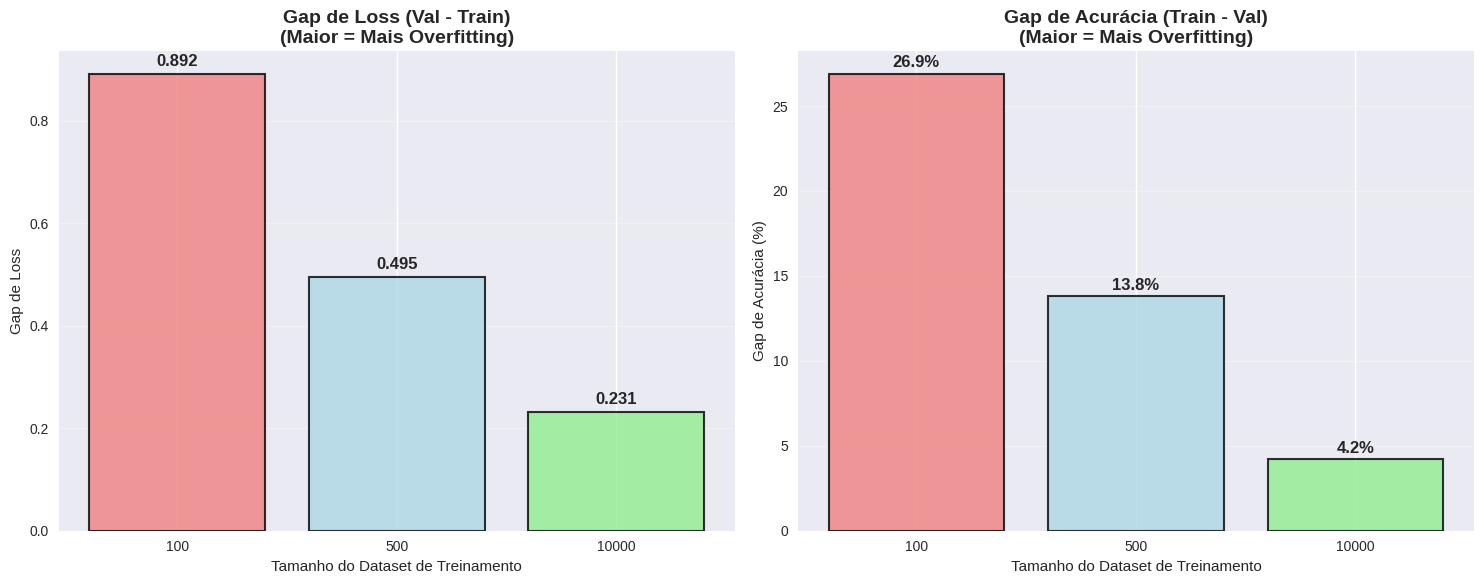

In [18]:
# Gr√°fico de barras comparativo do gap de overfitting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Extrair dados para os gr√°ficos
dataset_sizes_str = [str(size) for size in dataset_sizes]
loss_gaps = []
acc_gaps = []

for size in dataset_sizes:
    history = results_by_size[size]
    loss_gap = history['val_losses'][-1] - history['train_losses'][-1]
    acc_gap = history['train_accuracies'][-1] - history['val_accuracies'][-1]
    loss_gaps.append(loss_gap)
    acc_gaps.append(acc_gap)

# Gr√°fico de gap de loss
bars1 = ax1.bar(dataset_sizes_str, loss_gaps, color=['lightcoral', 'lightblue', 'lightgreen'],
                edgecolor='black', linewidth=1.5, alpha=0.8)
ax1.set_title('Gap de Loss (Val - Train)\n(Maior = Mais Overfitting)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Tamanho do Dataset de Treinamento')
ax1.set_ylabel('Gap de Loss')
ax1.grid(True, axis='y', alpha=0.3)

# Adicionar valores nas barras
for bar, value in zip(bars1, loss_gaps):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# Gr√°fico de gap de acur√°cia
bars2 = ax2.bar(dataset_sizes_str, acc_gaps, color=['lightcoral', 'lightblue', 'lightgreen'],
                edgecolor='black', linewidth=1.5, alpha=0.8)
ax2.set_title('Gap de Acur√°cia (Train - Val)\n(Maior = Mais Overfitting)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Tamanho do Dataset de Treinamento')
ax2.set_ylabel('Gap de Acur√°cia (%)')
ax2.grid(True, axis='y', alpha=0.3)

# Adicionar valores nas barras
for bar, value in zip(bars2, acc_gaps):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.2,
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### 4.7 Conclus√µes do Experimento

#### Implica√ß√µes Pr√°ticas:

- **Mais dados = Melhor generaliza√ß√£o**: O aumento do tamanho do dataset reduziu consistentemente o overfitting
- **Bias-Variance Tradeoff**: Datasets maiores reduzem a vari√¢ncia do modelo
- **Capacidade do Modelo**: A mesma arquitetura se beneficia diferentemente dependendo da quantidade de dados

#### Insights Te√≥ricos:

- O **ru√≠do nos dados** tem menos impacto quando h√° mais exemplos diversos
- A **complexidade do modelo** deve ser ajustada de acordo com a quantidade de dados dispon√≠veis

## Exerc√≠cio

Usando o dataset MNIST j√° carregado (500 exemplos), compare tr√™s arquiteturas diferentes e identifique qual apresenta menor overfitting. Analise os gaps de loss e acur√°cia entre treinamento e valida√ß√£o.

Dispositivo utilizado: cpu
Tamanho do conjunto de treinamento: 500
Tamanho do conjunto de valida√ß√£o: 1000

Treinando arquitetura: Simples (1 camada, 32 neur√¥nios)


Treinando modelo (hidden: 32, None):  25%|‚ñà‚ñà‚ñå       | 5/20 [00:02<00:08,  1.87it/s]

√âpoca 5/20: Train Loss: 1.2422, Train Acc: 62.60% | Val Loss: 1.2214, Val Acc: 62.80%


Treinando modelo (hidden: 32, None):  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 10/20 [00:04<00:03,  2.60it/s]

√âpoca 10/20: Train Loss: 0.8631, Train Acc: 73.00% | Val Loss: 1.0010, Val Acc: 66.70%


Treinando modelo (hidden: 32, None):  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 15/20 [00:06<00:01,  2.73it/s]

√âpoca 15/20: Train Loss: 0.7121, Train Acc: 76.20% | Val Loss: 0.9407, Val Acc: 68.20%


Treinando modelo (hidden: 32, None): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:08<00:00,  2.36it/s]


√âpoca 20/20: Train Loss: 0.6407, Train Acc: 77.20% | Val Loss: 0.9240, Val Acc: 68.20%

Treinando arquitetura: M√©dia (2 camadas, 64-32)


Treinando modelo (hidden: 64, 32):  25%|‚ñà‚ñà‚ñå       | 5/20 [00:02<00:06,  2.36it/s]

√âpoca 5/20: Train Loss: 0.8435, Train Acc: 83.00% | Val Loss: 0.8215, Val Acc: 78.90%


Treinando modelo (hidden: 64, 32):  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 10/20 [00:04<00:03,  2.64it/s]

√âpoca 10/20: Train Loss: 0.3098, Train Acc: 93.20% | Val Loss: 0.5413, Val Acc: 84.30%


Treinando modelo (hidden: 64, 32):  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 15/20 [00:06<00:02,  2.43it/s]

√âpoca 15/20: Train Loss: 0.1406, Train Acc: 97.80% | Val Loss: 0.4899, Val Acc: 85.50%


Treinando modelo (hidden: 64, 32): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:08<00:00,  2.45it/s]


√âpoca 20/20: Train Loss: 0.0669, Train Acc: 99.40% | Val Loss: 0.4880, Val Acc: 85.60%

Treinando arquitetura: Complexa (2 camadas, 128-64)


Treinando modelo (hidden: 128, 64):  25%|‚ñà‚ñà‚ñå       | 5/20 [00:02<00:05,  2.50it/s]

√âpoca 5/20: Train Loss: 0.4823, Train Acc: 87.20% | Val Loss: 0.5825, Val Acc: 82.20%


Treinando modelo (hidden: 128, 64):  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 10/20 [00:04<00:04,  2.08it/s]

√âpoca 10/20: Train Loss: 0.1627, Train Acc: 97.60% | Val Loss: 0.4727, Val Acc: 85.60%


Treinando modelo (hidden: 128, 64):  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 15/20 [00:06<00:02,  2.36it/s]

√âpoca 15/20: Train Loss: 0.0632, Train Acc: 99.60% | Val Loss: 0.4884, Val Acc: 84.90%


Treinando modelo (hidden: 128, 64): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:08<00:00,  2.29it/s]

√âpoca 20/20: Train Loss: 0.0255, Train Acc: 100.00% | Val Loss: 0.4996, Val Acc: 85.70%

=== TABELA RESUMO ===
                     Arquitetura Train Loss Val Loss Loss Gap Train Acc Val Acc Acc Gap
Simples (1 camada, 32 neur√¥nios)     0.6407   0.9240   0.2833    77.20%  68.20%   9.00%
        M√©dia (2 camadas, 64-32)     0.0669   0.4880   0.4212    99.40%  85.60%  13.80%
    Complexa (2 camadas, 128-64)     0.0255   0.4996   0.4741   100.00%  85.70%  14.30%


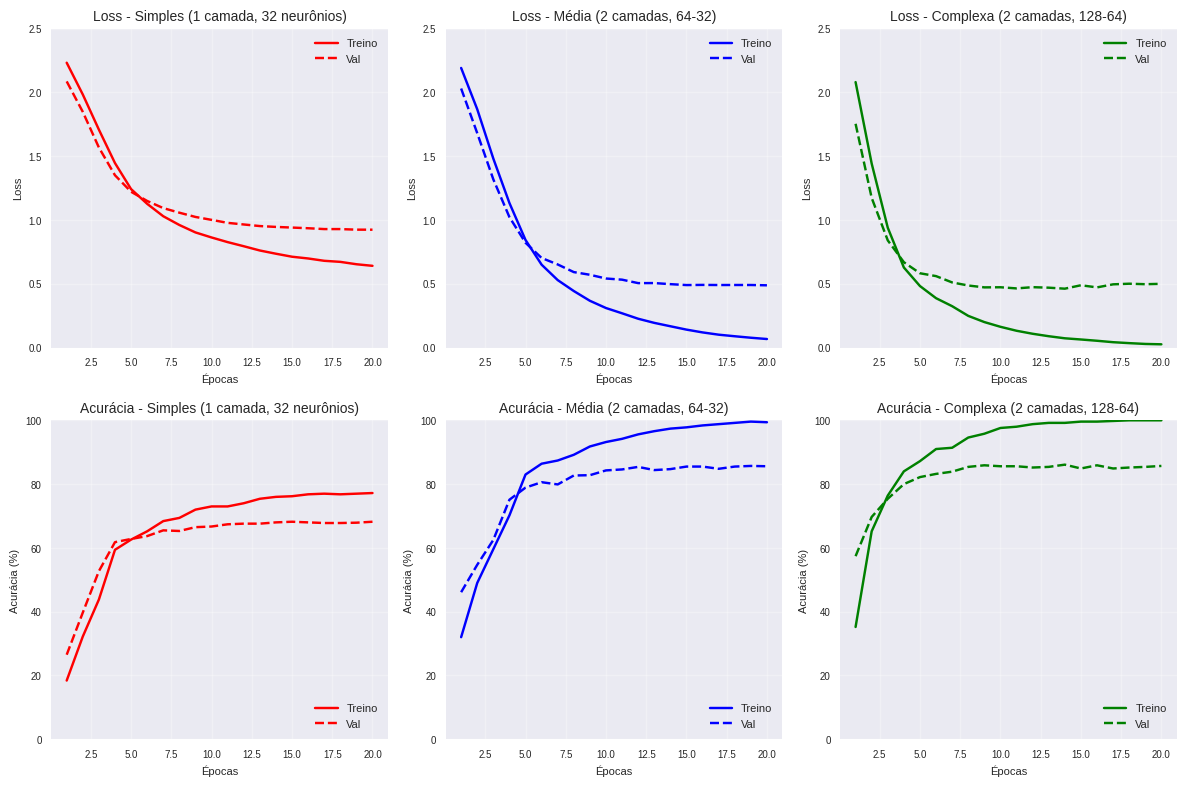

/tmp/ipython-input-824222348.py:242: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(arch_names, rotation=45, ha='right', fontsize=7)
/tmp/ipython-input-824222348.py:252: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(arch_names, rotation=45, ha='right', fontsize=7)


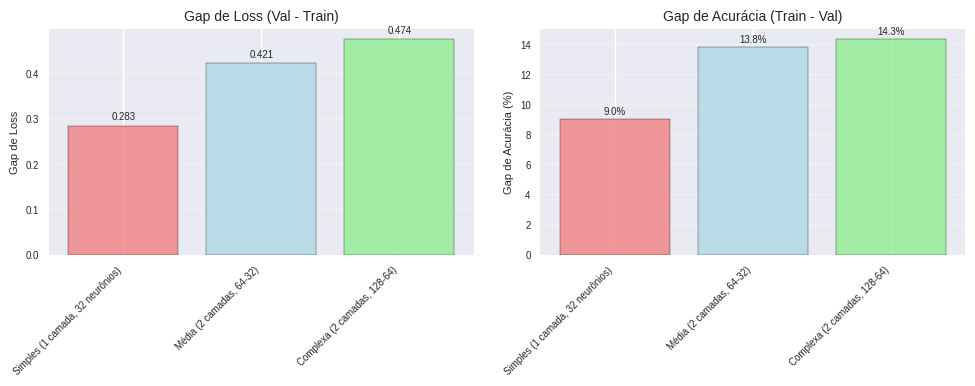


Arquitetura com menor gap de loss: Simples (1 camada, 32 neur√¥nios) (Loss Gap: 0.2833)
Arquitetura com menor gap de acur√°cia: Simples (1 camada, 32 neur√¥nios) (Acc Gap: 9.00%)


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Dispositivo utilizado: {device}')

# Carregar e preparar o dataset MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset_full = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

# Definir tamanhos
train_size = 500  # Conforme especificado
val_size = 1000   # Conjunto de valida√ß√£o fixo
batch_size = 64

# Criar subsets
val_indices = list(range(val_size))
train_indices = list(range(val_size, val_size + train_size))
train_dataset = Subset(train_dataset_full, train_indices)
val_dataset = Subset(train_dataset_full, val_indices)

# Criar DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Tamanho do conjunto de treinamento: {len(train_dataset)}')
print(f'Tamanho do conjunto de valida√ß√£o: {len(val_dataset)}')

# Definir a classe da rede neural
class MNISTClassifier(nn.Module):
    def __init__(self, hidden_size1, hidden_size2=None):
        super(MNISTClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, hidden_size1)
        if hidden_size2:  # Para arquiteturas com duas camadas ocultas
            self.fc2 = nn.Linear(hidden_size1, hidden_size2)
            self.fc3 = nn.Linear(hidden_size2, 10)
        else:  # Para arquitetura com uma camada oculta
            self.fc2 = nn.Linear(hidden_size1, 10)
            self.fc3 = None

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        if self.fc3:
            x = self.fc3(x)
        return x

# Fun√ß√£o de treinamento
def train_mnist_model(train_loader, val_loader, hidden_size1, hidden_size2=None, epochs=20, lr=0.001):
    model = MNISTClassifier(hidden_size1, hidden_size2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in tqdm(range(epochs), desc=f'Treinando modelo (hidden: {hidden_size1}, {hidden_size2})'):
        # Treinamento
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Avalia√ß√£o
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        # Calcular m√©tricas
        train_loss_avg = train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total
        val_loss_avg = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total

        train_losses.append(train_loss_avg)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss_avg)
        val_accuracies.append(val_acc)

        if (epoch + 1) % 5 == 0:
            print(f'√âpoca {epoch+1}/{epochs}: '
                  f'Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.2f}% | '
                  f'Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.2f}%')

    return model, {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }

# Definir tr√™s arquiteturas diferentes
architectures = [
    {'name': 'Simples (1 camada, 32 neur√¥nios)', 'hidden_size1': 32, 'hidden_size2': None},
    {'name': 'M√©dia (2 camadas, 64-32)', 'hidden_size1': 64, 'hidden_size2': 32},
    {'name': 'Complexa (2 camadas, 128-64)', 'hidden_size1': 128, 'hidden_size2': 64}
]

# Treinar e armazenar resultados
results = {}
models = {}
epochs = 20

for arch in architectures:
    print(f"\nTreinando arquitetura: {arch['name']}")
    model, history = train_mnist_model(
        train_loader=train_loader,
        val_loader=val_loader,
        hidden_size1=arch['hidden_size1'],
        hidden_size2=arch['hidden_size2'],
        epochs=epochs,
        lr=0.001
    )
    results[arch['name']] = history
    models[arch['name']] = model

# Analisar resultados
analysis_results = []
for arch in architectures:
    name = arch['name']
    history = results[name]

    final_train_loss = history['train_losses'][-1]
    final_val_loss = history['val_losses'][-1]
    final_train_acc = history['train_accuracies'][-1]
    final_val_acc = history['val_accuracies'][-1]

    loss_gap = final_val_loss - final_train_loss
    acc_gap = final_train_acc - final_val_acc

    analysis_results.append({
        'Arquitetura': name,
        'Train Loss': f'{final_train_loss:.4f}',
        'Val Loss': f'{final_val_loss:.4f}',
        'Loss Gap': f'{loss_gap:.4f}',
        'Train Acc': f'{final_train_acc:.2f}%',
        'Val Acc': f'{final_val_acc:.2f}%',
        'Acc Gap': f'{acc_gap:.2f}%'
    })

# Criar tabela resumo
df_analysis = pd.DataFrame(analysis_results)
print("\n=== TABELA RESUMO ===")
print(df_analysis.to_string(index=False))

# Visualizar curvas de treinamento
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # Reduzido de (18, 10)
colors = ['r', 'b', 'g']

for i, arch in enumerate(architectures):
    name = arch['name']
    history = results[name]

    # Curvas de loss
    ax_loss = axes[0, i]
    epochs_range = range(1, epochs + 1)
    ax_loss.plot(epochs_range, history['train_losses'], f'{colors[i]}-', label='Treino')
    ax_loss.plot(epochs_range, history['val_losses'], f'{colors[i]}--', label='Val')
    ax_loss.set_title(f'Loss - {name}', fontsize=10)
    ax_loss.set_xlabel('√âpocas', fontsize=8)
    ax_loss.set_ylabel('Loss', fontsize=8)
    ax_loss.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0), fontsize=8)
    ax_loss.grid(True, alpha=0.3)
    ax_loss.set_ylim([0, 2.5])
    ax_loss.tick_params(axis='both', labelsize=7)

    # Curvas de acur√°cia
    ax_acc = axes[1, i]
    ax_acc.plot(epochs_range, history['train_accuracies'], f'{colors[i]}-', label='Treino')
    ax_acc.plot(epochs_range, history['val_accuracies'], f'{colors[i]}--', label='Val')
    ax_acc.set_title(f'Acur√°cia - {name}', fontsize=10)
    ax_acc.set_xlabel('√âpocas', fontsize=8)
    ax_acc.set_ylabel('Acur√°cia (%)', fontsize=8)
    ax_acc.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0), fontsize=8)
    ax_acc.grid(True, alpha=0.3)
    ax_acc.set_ylim([0, 100])
    ax_acc.tick_params(axis='both', labelsize=7)

plt.tight_layout(pad=1.0)  # Ajuste fino para evitar sobreposi√ß√£o
plt.show()

# Gr√°fico de barras comparativo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))  # Reduzido de (15, 6)
arch_names = [arch['name'] for arch in architectures]
loss_gaps = [results[arch['name']]['val_losses'][-1] - results[arch['name']]['train_losses'][-1] for arch in architectures]
acc_gaps = [results[arch['name']]['train_accuracies'][-1] - results[arch['name']]['val_accuracies'][-1] for arch in architectures]

# Gr√°fico de gap de loss
bars1 = ax1.bar(arch_names, loss_gaps, color=['lightcoral', 'lightblue', 'lightgreen'], edgecolor='black', alpha=0.8)
ax1.set_title('Gap de Loss (Val - Train)', fontsize=10)
ax1.set_ylabel('Gap de Loss', fontsize=8)
ax1.grid(True, axis='y', alpha=0.3)
ax1.tick_params(axis='both', labelsize=7)
ax1.set_xticklabels(arch_names, rotation=45, ha='right', fontsize=7)
for bar, value in zip(bars1, loss_gaps):
    ax1.text(bar.get_x() + bar.get_width()/2., value + 0.01, f'{value:.3f}', ha='center', va='bottom', fontsize=7)

# Gr√°fico de gap de acur√°cia
bars2 = ax2.bar(arch_names, acc_gaps, color=['lightcoral', 'lightblue', 'lightgreen'], edgecolor='black', alpha=0.8)
ax2.set_title('Gap de Acur√°cia (Train - Val)', fontsize=10)
ax2.set_ylabel('Gap de Acur√°cia (%)', fontsize=8)
ax2.grid(True, axis='y', alpha=0.3)
ax2.tick_params(axis='both', labelsize=7)
ax2.set_xticklabels(arch_names, rotation=45, ha='right', fontsize=7)
for bar, value in zip(bars2, acc_gaps):
    ax2.text(bar.get_x() + bar.get_width()/2., value + 0.2, f'{value:.1f}%', ha='center', va='bottom', fontsize=7)

plt.tight_layout(pad=1.0)  # Ajuste fino para evitar sobreposi√ß√£o
plt.show()

# Identificar arquitetura com menor overfitting
min_loss_gap_idx = loss_gaps.index(min(loss_gaps))
min_acc_gap_idx = acc_gaps.index(min([abs(g) for g in acc_gaps]))
print(f"\nArquitetura com menor gap de loss: {architectures[min_loss_gap_idx]['name']} (Loss Gap: {loss_gaps[min_loss_gap_idx]:.4f})")
print(f"Arquitetura com menor gap de acur√°cia: {architectures[min_acc_gap_idx]['name']} (Acc Gap: {acc_gaps[min_acc_gap_idx]:.2f}%)")